<a href="https://colab.research.google.com/github/Pineappledeydre/nafld_prediction/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Loading & Library Instalation

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from scipy.stats import ttest_ind, stats
import csv
from scipy.special import expit

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc,
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE,SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

In [ ]:
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
!pip install shap
!pip install interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 25.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━

In [ ]:
import shap
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
combined_df = pd.read_csv('/content/drive/MyDrive/Data/KIM_2024/Данные_Почищенные/for_analysis_merged.csv') # already in english
# observation_merged_df = pd.read_csv('/content/drive/MyDrive/Data/KIM_2024/Данные_Почищенные/observation_merged.csv')
# comparison_merged_df = pd.read_csv (('/content/drive/MyDrive/Data/KIM_2024/Данные_Почищенные/comparison_merged.csv'))

## EDA / Preprocessing

### Sickness (Group)
Target Variable: Group (1 = NAFLD, 0 = Healthy)
Class Distribution:
* 120 Sick (NAFLD)
* 60 Healthy
(Imbalanced: 2:1 sick-to-healthy ratio)

### Gender
* 1 - female
* 2 - male

In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Gender                        180 non-null    int64  
 1   Age                           180 non-null    int64  
 2   Body Fat (%)                  180 non-null    float64
 3   Visceral Fat (%)              180 non-null    int64  
 4   Skeleton (%)                  180 non-null    float64
 5   Bone Mass (kg)                180 non-null    float64
 6   Water (%)                     180 non-null    float64
 7   Basal Metabolic Rate (kcal)   180 non-null    int64  
 8   Chest Circumference (cm)      180 non-null    int64  
 9   Waist Circumference (cm)      180 non-null    int64  
 10  Abdominal Circumference (cm)  180 non-null    int64  
 11  Hip Circumference (cm)        180 non-null    float64
 12  BMI                           180 non-null    float64
 13  ALT  

In [ ]:
combined_df.head()

Gender  Age  Body Fat (%)  Visceral Fat (%)  Skeleton (%)  Bone Mass (kg)  \
0       1   44          40.2                12          30.7             2.0   
1       1   33          32.6                 9          36.4             2.8   
2       1   45          40.7                17          29.8             3.1   
3       0   25          29.7                15          40.3             3.7   
4       1   48          42.8                14          31.1             2.1   

   Water (%)  Basal Metabolic Rate (kcal)  Chest Circumference (cm)  \
0       41.9                         1295                        96   
1       48.6                         1435                        99   
2       40.8                         1537                       114   
3       51.3                         1906                       110   
4       44.7                         1265                        98   

   Waist Circumference (cm)  ...  Triglycerides  Total Bilirubin  \
0                        87  ...           1.20            11.96   
1                        89  ...           0.92            10.10   
2                        97  ...           1.70            11.64   
3                       100  ...           1.30            15.40   
4                        94  ...           1.62            11.20   

   Direct Bilirubin  Glucose  Insulin  Ferritin   CRP  Total Protein  \
0               5.7     5.30    10.54      38.1  0.97           66.3   
1               4.0     4.90     9.20      74.3  1.00           64.1   
2               5.7     5.33    17.40     180.0  4.60           64.7   
3               7.2     5.41    14.70      96.5  0.78           73.9   
4               5.4     5.67    11.60     112.8  3.45           74.2   

   Uric Acid  Group  
0     279.30      1  
1     150.40      1  
2     424.71      1  
3     286.00      1  
4     361.90      1  

[5 rows x 30 columns]

In [ ]:
combined_df.describe()[1:].T

mean         std      min        25%  \
Gender                           0.533333    0.500279     0.00     0.0000   
Age                             43.094444    9.717057    25.00    36.0000   
Body Fat (%)                    33.636111    5.912847    17.70    29.8000   
Visceral Fat (%)                13.466667    4.208796     5.00    11.0000   
Skeleton (%)                    35.883889    4.182194    27.10    32.8000   
Bone Mass (kg)                   3.051111    0.621000     2.00     2.6000   
Water (%)                       46.559444    4.706369    30.70    43.5000   
Basal Metabolic Rate (kcal)   1616.000000  258.080733  1179.00  1382.7500   
Chest Circumference (cm)       108.944444    9.925827    89.00   101.0000   
Waist Circumference (cm)        98.938889   11.140627    76.00    92.0000   
Abdominal Circumference (cm)   104.655556   10.282231    84.00    97.0000   
Hip Circumference (cm)         107.036111    8.512894    86.00   102.0000   
BMI                             29.837667    4.224632    20.93    27.3925   
ALT                             43.122778   22.412020     7.10    26.8750   
AST                             32.582556   16.582904     9.00    21.0000   
GGT                             35.558889   18.853874     8.00    21.0000   
ALP                             78.851111   22.232835    42.00    61.6750   
Total Cholesterol                5.810500    0.852744     3.26     5.2000   
LDL                              3.373556    1.036603     1.30     2.7000   
HDL                              1.550722    0.363629     0.70     1.3000   
Triglycerides                    1.562444    0.834171     0.36     0.9000   
Total Bilirubin                 11.065556    6.164485     4.40     6.6750   
Direct Bilirubin                 4.588556    2.622515     1.90     2.8000   
Glucose                          5.483556    0.642911     4.10     4.9450   
Insulin                         17.226222    7.160860     7.00    11.0000   
Ferritin                       165.833333  132.913325    17.90    65.6000   
CRP                              2.982278    2.491545     0.00     1.0000   
Total Protein                   71.030000    5.294056    53.70    67.4750   
Uric Acid                      321.798944  104.242578   118.00   223.3000   
Group                            0.666667    0.472719     0.00     0.0000   

                                   50%        75%      max  
Gender                           1.000     1.0000     1.00  
Age                             43.000    50.0000    60.00  
Body Fat (%)                    34.200    37.9000    47.40  
Visceral Fat (%)                13.000    16.0000    26.00  
Skeleton (%)                    36.150    38.9500    48.70  
Bone Mass (kg)                   2.900     3.5000     4.70  
Water (%)                       46.400    49.2250    61.40  
Basal Metabolic Rate (kcal)   1596.500  1835.5000  2156.00  
Chest Circumference (cm)       108.500   117.2500   132.00  
Waist Circumference (cm)        97.500   106.0000   134.00  
Abdominal Circumference (cm)   103.500   112.2500   135.00  
Hip Circumference (cm)         106.000   112.0000   134.00  
BMI                             29.340    32.2875    42.32  
ALT                             38.950    54.1250   123.70  
AST                             29.000    38.7500   104.00  
GGT                             31.650    43.5500   144.00  
ALP                             74.000    94.0000   156.00  
Total Cholesterol                5.900     6.4000     7.80  
LDL                              3.335     4.1225     5.90  
HDL                              1.460     1.8000     2.80  
Triglycerides                    1.345     2.0100     5.51  
Total Bilirubin                  8.550    13.6250    31.40  
Direct Bilirubin                 3.600     5.3250    17.40  
Glucose                          5.600     5.9000     7.90  
Insulin                         16.000    21.6250    41.00  
Ferritin                       117.250   248.7500   741.00  
CR

### Correlation

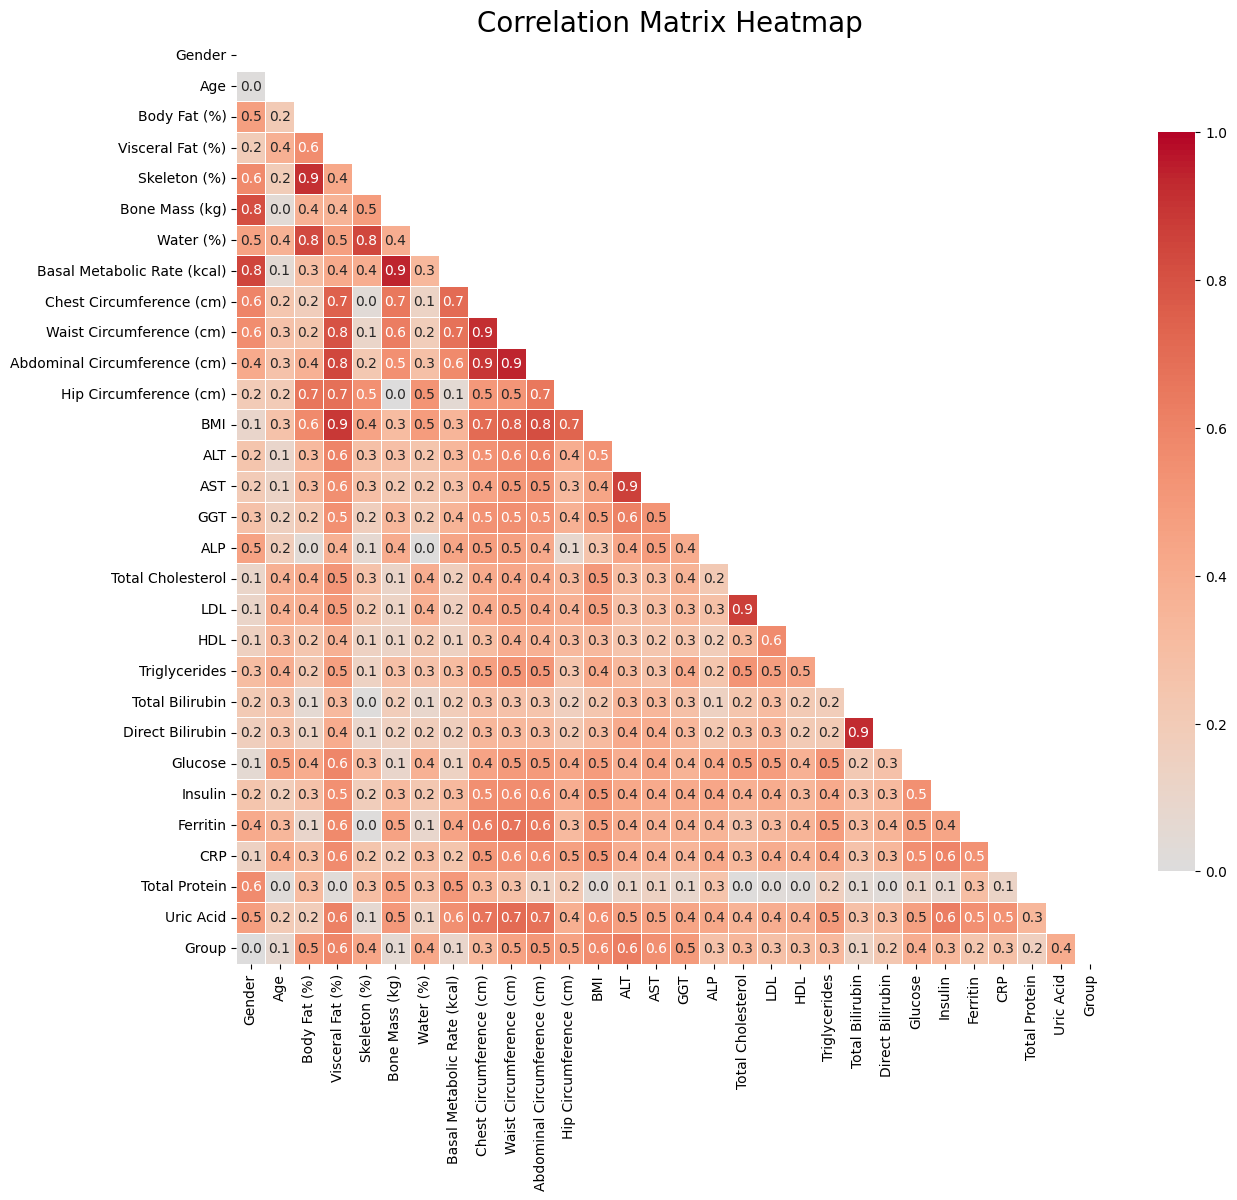

In [ ]:
correlation_matrix = combined_df.corr().abs()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.1f',
                      linewidths=0.5, vmin=0, vmax=1, mask=mask,
                      cbar_kws={"shrink": .8})
plt.title('Correlation Matrix Heatmap', size=20)
plt.xticks(size=10)
plt.yticks(size=10)

plt.show()

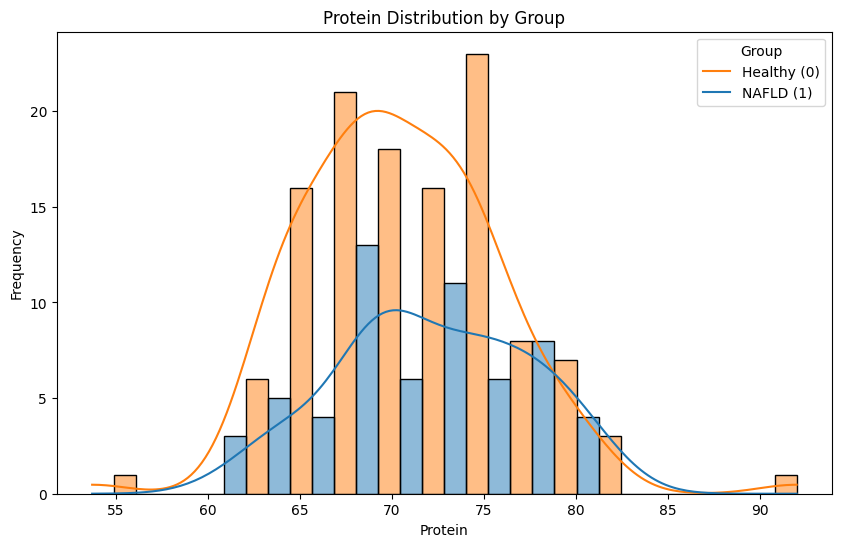

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data= combined_df, x="Total Protein",
             hue="Group", multiple="dodge", kde=True)
plt.title("Protein Distribution by Group")
plt.xlabel("Protein")
plt.ylabel("Frequency")
plt.legend(title="Group", labels=["Healthy (0)", "NAFLD (1)"])
plt.show()

In [ ]:
mean_protein_group_0 = combined_df[combined_df['Group'] == 0]['Total Protein'].mean()
mean_protein_group_1 = combined_df[combined_df['Group'] == 1]['Total Protein'].mean()

mean_protein_group_0, mean_protein_group_1

(72.235, 70.4275)

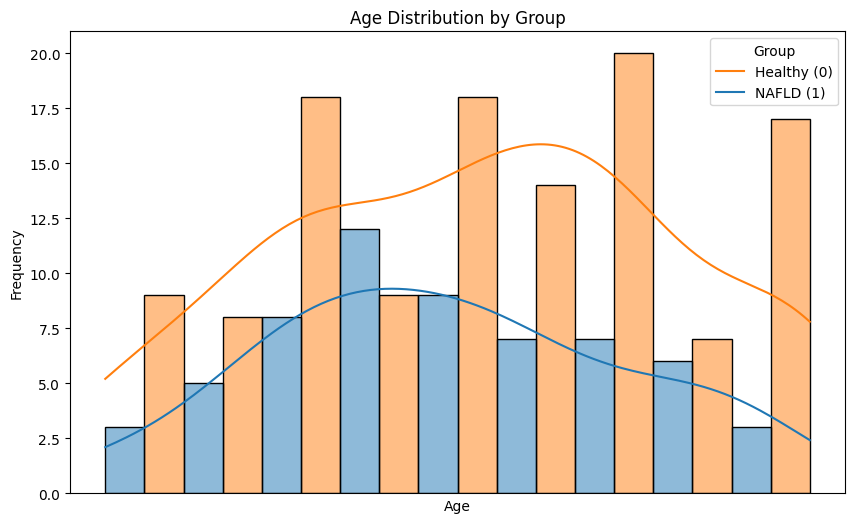

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=combined_df, x="Age", hue="Group", multiple="dodge", kde=True)
plt.title("Age Distribution by Group")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend(title="Group", labels=["Healthy (0)", "NAFLD (1)"])

age_ticks = range(int(combined_df["Age"].min()), int(combined_df["Age"].max()) + 1, 5)
ax.set_xticks([])
ax.set_xticklabels([])

plt.show()


In [ ]:
mean_age_group_0 = combined_df[combined_df['Group'] == 0]['Age'].mean()
mean_age_group_1 = combined_df[combined_df['Group'] == 1]['Age'].mean()

mean_age_group_0, mean_age_group_1

(42.03333333333333, 43.625)

## Model Building

## Regularization

### Lasso

In [ ]:
X = combined_df.drop(columns=['Group'])
y = combined_df['Group']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

log_reg_lasso = LogisticRegression(penalty='l1', solver='saga', C=0.2, max_iter=10000)  # L1 with stronger penalty
log_reg_lasso.fit(X_train, y_train)

lasso_coefficients = log_reg_lasso.coef_[0]
non_zero_indices = np.where(lasso_coefficients != 0)[0]
selected_features = X.columns[non_zero_indices]

print("Selected Features (Non-zero Coefficients):", selected_features)

Selected Features (Non-zero Coefficients): Index(['Age', 'Body Fat (%)', 'Visceral Fat (%)', 'BMI', 'ALT', 'AST', 'GGT',
       'Total Protein'],
      dtype='object')


Lasso Logistic Regression Test Accuracy: 0.9444
Confusion Matrix on Test Data:
[[10  2]
 [ 0 24]]


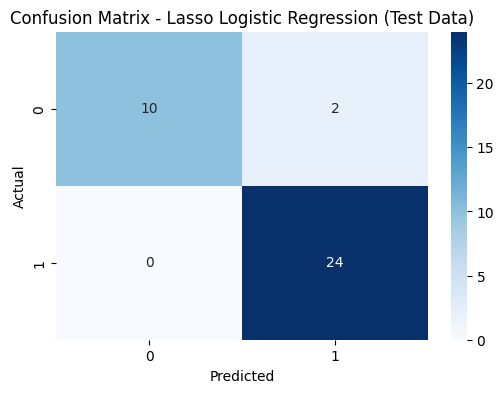


Classification Report on Test Data:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.92      1.00      0.96        24

    accuracy                           0.94        36
   macro avg       0.96      0.92      0.93        36
weighted avg       0.95      0.94      0.94        36



In [ ]:
y_test_pred_class = log_reg_lasso.predict(X_test)
y_test_pred_proba = log_reg_lasso.predict_proba(X_test)[:, 1]

cm_test = confusion_matrix(y_test, y_test_pred_class)
test_accuracy = accuracy_score(y_test, y_test_pred_class)

print(f"Lasso Logistic Regression Test Accuracy: {test_accuracy:.4f}")
print("Confusion Matrix on Test Data:")
print(cm_test)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Lasso Logistic Regression (Test Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_test_pred_class))

In [ ]:
unscaled_coefficients = log_reg_lasso.coef_[0] / scaler.scale_

unscaled_intercept = log_reg_lasso.intercept_ - np.sum((scaler.mean_ / scaler.scale_) * log_reg_lasso.coef_[0])

unscaled_coefficients_series = pd.Series(unscaled_coefficients, index=X.columns)

non_zero_coefficients = unscaled_coefficients_series[unscaled_coefficients_series != 0]
print("Non-Zero Unscaled Coefficients:")
print(non_zero_coefficients)

print("Unscaled Intercept:", unscaled_intercept)

Non-Zero Unscaled Coefficients:
Age                -0.003635
Body Fat (%)        0.072961
Visceral Fat (%)    0.157963
BMI                 0.041570
ALT                 0.076707
AST                 0.008688
GGT                 0.025089
Total Protein      -0.039637
dtype: float64
Unscaled Intercept: [-5.58796147]


In [ ]:
def predict_with_unscaled(features):
    y_pred = unscaled_intercept.item()  # Ensure it's a scalar
    for feature, coef in zip(X.columns, unscaled_coefficients):
        y_pred += coef * features[feature]
    return y_pred

raw_predictions = combined_df.apply(predict_with_unscaled, axis=1)

predicted_probabilities = 1 / (1 + np.exp(-raw_predictions.to_numpy().flatten()))

predicted_classes = (predicted_probabilities >= 0.5).astype(int)

results_df = pd.DataFrame({
    'raw_prediction': raw_predictions,
    'predicted_probability': predicted_probabilities,
    'predicted_class': predicted_classes,
    'actual_class': combined_df['Group']
})

print(results_df.head())

cm = confusion_matrix(results_df['actual_class'], results_df['predicted_class'])
print("Confusion Matrix:")
print(cm)

accuracy = accuracy_score(results_df['actual_class'], results_df['predicted_class'])
print(f"Accuracy: {accuracy:.4f}")

report = classification_report(results_df['actual_class'], results_df['predicted_class'])
print("Classification Report:")
print(report)

   raw_prediction  predicted_probability  predicted_class  actual_class
0        1.312170               0.787876                1             1
1        0.808402               0.691769                1             1
2        4.346130               0.987209                1             1
3        2.154658               0.896103                1             1
4        6.491304               0.998486                1             1
Confusion Matrix:
[[ 51   9]
 [  3 117]]
Accuracy: 0.9333
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89        60
           1       0.93      0.97      0.95       120

    accuracy                           0.93       180
   macro avg       0.94      0.91      0.92       180
weighted avg       0.93      0.93      0.93       180



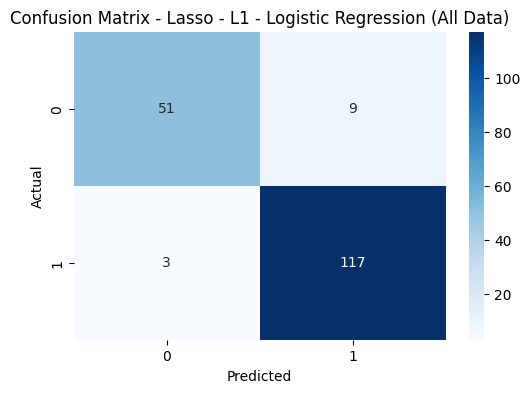

In [ ]:
cm = confusion_matrix(results_df['actual_class'], results_df['predicted_class'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Lasso - L1 - Logistic Regression (All Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Elastic Net

In [ ]:
X = combined_df.drop(columns=['Group'])
y = combined_df['Group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg_elastic = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=10000,)  # Elastic Net
rfe = RFE(estimator=log_reg_elastic, n_features_to_select=10)
rfe.fit(X_train_scaled, y_train)

selected_features = X.columns[rfe.support_]
print(f"Selected Features: {selected_features}")

X_train_selected = rfe.transform(X_train_scaled)
X_test_selected = rfe.transform(X_test_scaled)

log_reg_elastic.fit(X_train_selected, y_train)

y_test_pred_class = log_reg_elastic.predict(X_test_selected)
y_test_pred_proba = log_reg_elastic.predict_proba(X_test_selected)[:, 1]

Selected Features: Index(['Body Fat (%)', 'Visceral Fat (%)', 'Chest Circumference (cm)', 'BMI',
       'ALT', 'AST', 'GGT', 'ALP', 'LDL', 'Ferritin'],
      dtype='object')


Elastic Net Logistic Regression Test Accuracy: 0.9167
Confusion Matrix on Test Data:
[[10  2]
 [ 1 23]]


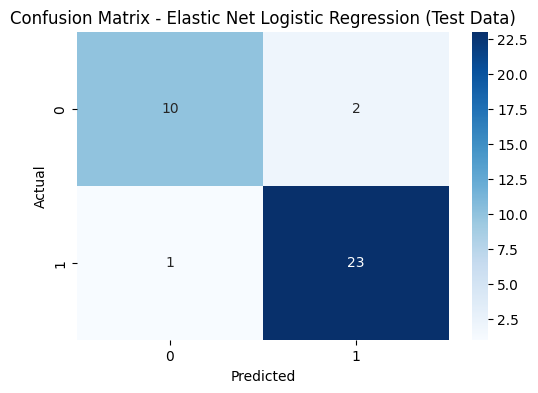


Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.92      0.96      0.94        24

    accuracy                           0.92        36
   macro avg       0.91      0.90      0.90        36
weighted avg       0.92      0.92      0.92        36



In [ ]:
cm_test = confusion_matrix(y_test, y_test_pred_class)
test_accuracy = accuracy_score(y_test, y_test_pred_class)

print(f"Elastic Net Logistic Regression Test Accuracy: {test_accuracy:.4f}")
print("Confusion Matrix on Test Data:")
print(cm_test)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Elastic Net Logistic Regression (Test Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_test_pred_class))

In [ ]:
unscaled_coefficients = log_reg_elastic.coef_[0] / scaler.scale_[rfe.support_]

unscaled_intercept = log_reg_elastic.intercept_ - np.sum((scaler.mean_[rfe.support_] / scaler.scale_[rfe.support_]) * log_reg_elastic.coef_[0])
unscaled_coefficients_series = pd.Series(unscaled_coefficients, index=selected_features)

non_zero_coefficients = unscaled_coefficients_series[unscaled_coefficients_series != 0]
print("Non-Zero Unscaled Coefficients:")
print(non_zero_coefficients)

print("Unscaled Intercept:", unscaled_intercept)

def predict_with_unscaled(features):
    y_pred = unscaled_intercept.item()
    for feature, coef in zip(selected_features, unscaled_coefficients):
        y_pred += coef * features[feature]
    return y_pred

raw_predictions = combined_df[selected_features].apply(predict_with_unscaled, axis=1)
predicted_probabilities = 1 / (1 + np.exp(-raw_predictions.to_numpy().flatten()))
predicted_classes = (predicted_probabilities >= 0.5).astype(int)

results_df = pd.DataFrame({
    'raw_prediction': raw_predictions,
    'predicted_probability': predicted_probabilities,
    'predicted_class': predicted_classes,
    'actual_class': combined_df['Group']
})

print(results_df.head())

cm = confusion_matrix(results_df['actual_class'], results_df['predicted_class'])
print("Confusion Matrix:")
print(cm)

accuracy = accuracy_score(results_df['actual_class'], results_df['predicted_class'])
print(f"Accuracy: {accuracy:.4f}")

report = classification_report(results_df['actual_class'], results_df['predicted_class'])
print("Classification Report:")
print(report)


Non-Zero Unscaled Coefficients:
Body Fat (%)                0.157095
Visceral Fat (%)            0.316171
Chest Circumference (cm)   -0.075790
BMI                         0.297651
ALT                         0.104187
AST                         0.069180
GGT                         0.088503
ALP                         0.018072
LDL                        -0.657519
Ferritin                   -0.005999
dtype: float64
Unscaled Intercept: [-14.97402905]
   raw_prediction  predicted_probability  predicted_class  actual_class
0        2.491978               0.923578                1             1
1        1.006469               0.732329                1             1
2        7.477641               0.999435                1             1
3        4.270257               0.986215                1             1
4       13.803289               0.999999                1             1
Confusion Matrix:
[[ 56   4]
 [  3 117]]
Accuracy: 0.9611
Classification Report:
              precision    recall  

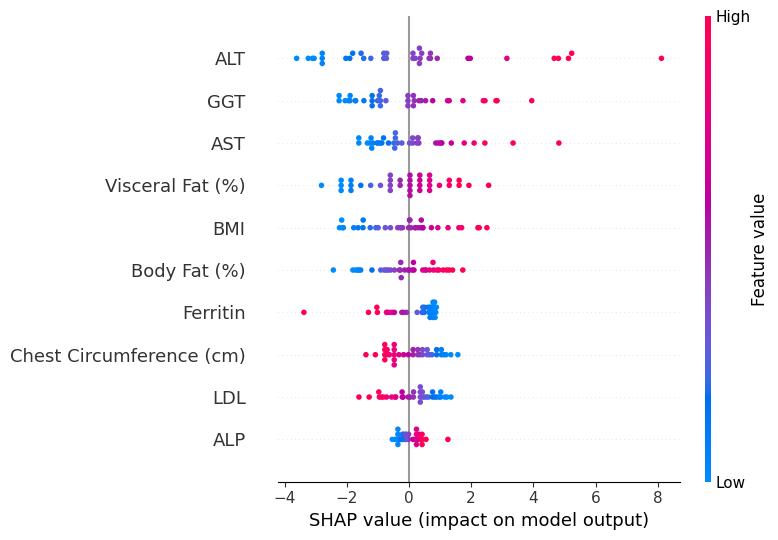

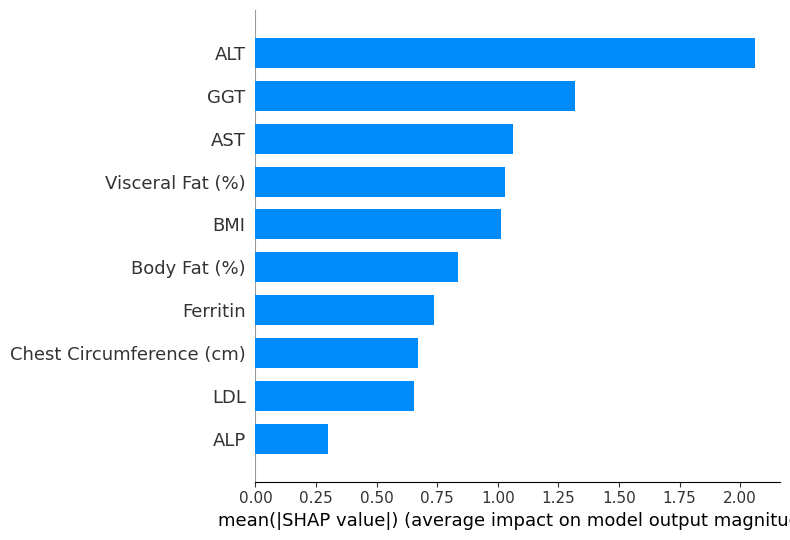

In [ ]:
selected_features = X.columns[rfe.support_]

explainer = shap.LinearExplainer(log_reg_elastic,
                                 X_train_scaled[:, rfe.support_])
shap_values = explainer.shap_values(X_test_scaled[:, rfe.support_])

sample_index = 0
shap.force_plot(explainer.expected_value, shap_values[sample_index], X_test.iloc[sample_index, :][selected_features])

shap.summary_plot(shap_values, X_test[selected_features], feature_names=selected_features)

shap.summary_plot(shap_values, X_test[selected_features], plot_type="bar", feature_names=selected_features)

## VIF

In [ ]:
X_features = combined_df.drop(columns=['Group'])

# VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_features.columns
vif_data["VIF"] = [variance_inflation_factor(X_features.values, i) for i in range(X_features.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

                         Feature          VIF
10  Abdominal Circumference (cm)  2048.121295
8       Chest Circumference (cm)  1321.476154
9       Waist Circumference (cm)  1319.557255
11        Hip Circumference (cm)   723.962115
7    Basal Metabolic Rate (kcal)   573.393999
4                   Skeleton (%)   516.048679
6                      Water (%)   457.706151
12                           BMI   371.613967
17             Total Cholesterol   350.347706
5                 Bone Mass (kg)   322.169576
27                 Total Protein   311.993935
2                   Body Fat (%)   214.753571
23                       Glucose   200.755288
3               Visceral Fat (%)    98.785053
18                           LDL    90.865628
19                           HDL    45.606341
1                            Age    41.762744
21               Total Bilirubin    37.442833
22              Direct Bilirubin    36.517881
28                     Uric Acid    31.472136
16                           ALP  

## PCA

In [ ]:
# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined_df.drop(columns=["Group"]))

pca = PCA(n_components=10)  # reduce to 10 PC
X_pca = pca.fit_transform(X_scaled)

print("Explained Variance:", pca.explained_variance_ratio_)

Explained Variance: [0.39324789 0.1739674  0.06365703 0.05812331 0.04232789 0.03709592
 0.02874428 0.02599793 0.02530617 0.02056839]


1. **The dataset has a few dominant patterns**:
   - **PC1 (39.3%)** and **PC2 (17.4%)** capture most of the variation.
   - The remaining components explain smaller portions.
2. **PCA has successfully reduced dimensionality**:
   - Instead of 29 original features, you now have **10 independent components**.
   - This significantly reduces **multicollinearity** (VIF will now be low).
3. **We will lose interpretability**:
   - PCA **transforms original features** into new uncorrelated components.
-> We **won’t be able to directly interpret which features drive NAFLD** unless we check PCA loadings.

In [ ]:
pca_loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(10)], index=combined_df.drop(columns=["Group"]).columns)

print("Top Features in PC1:")
print(pca_loadings["PC1"].abs().sort_values(ascending=False).head(5))

print("\nTop Features in PC2:")
print(pca_loadings["PC2"].abs().sort_values(ascending=False).head(5))

print("\nTop Features in PC3:")
print(pca_loadings["PC3"].abs().sort_values(ascending=False).head(5))

Top Features in PC1:
Abdominal Circumference (cm)    0.266456
Waist Circumference (cm)        0.266221
Visceral Fat (%)                0.262767
Chest Circumference (cm)        0.253650
BMI                             0.241686
Name: PC1, dtype: float64

Top Features in PC2:
Skeleton (%)      0.375254
Gender            0.374599
Body Fat (%)      0.360115
Water (%)         0.353823
Bone Mass (kg)    0.343188
Name: PC2, dtype: float64

Top Features in PC3:
Total Bilirubin      0.436046
Direct Bilirubin     0.396734
Age                  0.346882
LDL                  0.299924
Total Cholesterol    0.239639
Name: PC3, dtype: float64


### Lasso after PCA

In [ ]:
# the top features from PCA loadings
selected_features = [
    "Abdominal Circumference (cm)", "Waist Circumference (cm)", "Visceral Fat (%)",
    "Chest Circumference (cm)", "BMI", "Skeleton (%)", "Gender", "Body Fat (%)",
    "Water (%)", "Bone Mass (kg)", "Total Bilirubin", "Direct Bilirubin", "Age", "LDL", "Total Cholesterol"
]

X_reduced = combined_df[selected_features]
y = combined_df["Group"]

# standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Lasso Logistic Regression
log_reg_lasso = LogisticRegression(penalty='l1', solver='saga', C=0.2, max_iter=10000)
log_reg_lasso.fit(X_train, y_train)

y_pred = log_reg_lasso.predict(X_test)
y_pred_proba = log_reg_lasso.predict_proba(X_test)[:, 1]


print(f"Lasso Logistic Regression Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Lasso Logistic Regression Test Accuracy: 0.9167
Confusion Matrix:
 [[ 9  3]
 [ 0 24]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86        12
           1       0.89      1.00      0.94        24

    accuracy                           0.92        36
   macro avg       0.94      0.88      0.90        36
weighted avg       0.93      0.92      0.91        36



In [ ]:
lasso_coefficients = log_reg_lasso.coef_[0]
non_zero_coefficients = pd.Series(lasso_coefficients, index=selected_features)
print("Selected Features & Coefficients:\n", non_zero_coefficients[non_zero_coefficients != 0])

Selected Features & Coefficients:
 Abdominal Circumference (cm)    0.187795
Visceral Fat (%)                1.342495
BMI                             0.044536
Skeleton (%)                   -0.064837
Body Fat (%)                    0.417281
Age                            -0.260536
dtype: float64


In [ ]:
X_age = combined_df[['Age']]
y = combined_df["Group"]

scaler = StandardScaler()
X_age_scaled = scaler.fit_transform(X_age)

log_reg_age = LogisticRegression()
log_reg_age.fit(X_age_scaled, y)

print(f"Age Coefficient in Simple Model: {log_reg_age.coef_[0][0]:.4f}")

Age Coefficient in Simple Model: 0.1610


Since **Age has a positive coefficient (0.1610) in a simple model**, but **a negative coefficient (-0.2605) in Lasso**, this confirms that **Lasso is distorting the effect of Age due to collinearity or regularization pressure.**

### Elastic Net after PCA

In [ ]:
X_selected = combined_df[[
    "Abdominal Circumference (cm)", "Waist Circumference (cm)", "Visceral Fat (%)",
    "Chest Circumference (cm)", "BMI", "Skeleton (%)", "Gender", "Body Fat (%)",
    "Water (%)", "Bone Mass (kg)", "Total Bilirubin", "Direct Bilirubin", "Age", "LDL", "Total Cholesterol"
]]

log_reg_elastic = LogisticRegression(penalty='elasticnet', solver='saga', C=0.2, l1_ratio=0.5, max_iter=10000)
log_reg_elastic.fit(X_train, y_train)

elastic_coefficients = pd.Series(log_reg_elastic.coef_[0], index=X_selected.columns)
print("Elastic Net Coefficients:\n", elastic_coefficients)

Elastic Net Coefficients:
 Abdominal Circumference (cm)    0.446435
Waist Circumference (cm)        0.051098
Visceral Fat (%)                0.921988
Chest Circumference (cm)       -0.046470
BMI                             0.319252
Skeleton (%)                   -0.205004
Gender                          0.000000
Body Fat (%)                    0.295154
Water (%)                      -0.118547
Bone Mass (kg)                 -0.090860
Total Bilirubin                 0.000000
Direct Bilirubin                0.167350
Age                            -0.370214
LDL                             0.000000
Total Cholesterol               0.000000
dtype: float64


Since LDL, Total Cholesterol, and Total Bilirubin were removed, we can force their inclusion to check if Age still behaves strangely.

In [ ]:
selected_features_fixed = [
    "Abdominal Circumference (cm)", "Visceral Fat (%)", "BMI",
    "Skeleton (%)", "Body Fat (%)", "Water (%)", "Bone Mass (kg)",
    "Direct Bilirubin", "Age", "LDL", "Total Cholesterol"
]

X_fixed = combined_df[selected_features_fixed]
y = combined_df["Group"]

X_train, X_test, y_train, y_test = train_test_split(X_fixed, y, test_size=0.2, random_state=42)

log_reg_elastic_fixed = LogisticRegression(penalty='elasticnet', solver='saga', C=0.2, l1_ratio=0.5, max_iter=10000)
log_reg_elastic_fixed.fit(X_train, y_train)

elastic_coefficients_fixed = pd.Series(log_reg_elastic_fixed.coef_[0], index=X_fixed.columns)
print("Elastic Net Coefficients (Fixed):\n", elastic_coefficients_fixed)


Elastic Net Coefficients (Fixed):
 Abdominal Circumference (cm)    0.065877
Visceral Fat (%)                0.400381
BMI                             0.000000
Skeleton (%)                   -0.142177
Body Fat (%)                    0.022625
Water (%)                      -0.069329
Bone Mass (kg)                 -0.009337
Direct Bilirubin                0.124103
Age                            -0.083136
LDL                            -0.055857
Total Cholesterol               0.000000
dtype: float64


The **Elastic Net model after forcing LDL and Total Cholesterol** shows some **improvements, but Age is still negative (-0.0831)** and **Total Cholesterol was completely removed (0.0000).**  

- Although **less extreme than before (-0.37 → -0.0831)**, Age is **still negative**.

- LDL was kept (-0.0559), but **Total Cholesterol was fully removed**.

- Since **Visceral Fat (%) and Body Fat (%) were kept**, BMI was considered redundant.

## **Explainable Boosting Machine**

In [ ]:
# training tracking
def train_ebm_with_progress(ebm, X_train, y_train):
    n_epochs = 10  # Number of progress steps - arbitrary for visualization
    for i in tqdm(range(n_epochs), desc="Training EBM Progress"):
        ebm.fit(X_train, y_train)
    return ebm

**Final Feature Set**

We’ll include:
1. **Best features from Elastic Net**  
2. **Important features from PCA Loadings**  
3. **Key clinical markers from domain knowledge**  
4. **Minimized collinearity (one per correlated group)**  

```python
selected_features_ebm = [
    # Body Composition & Measurements (4)
    "Abdominal Circumference (cm)", "Visceral Fat (%)", "Skeleton (%)", "Body Fat (%)",
    
    # Liver Enzymes & Function Markers (4)
    "ALT", "AST", "GGT", "Direct Bilirubin",
    
    # Metabolic Markers (4)
    "Glucose", "Insulin", "Ferritin", "CRP",

    # Lipid Profile (2)
    "LDL", "Triglycerides",

    # Inflammatory & Other Risk Factors (3)
    "Total Protein", "Age", "Gender"
]
```
**This gives us 17 features**—more than 10, while still avoiding redundancy.  

In [ ]:
selected_features_ebm = [
    "Abdominal Circumference (cm)", "Visceral Fat (%)", "Skeleton (%)", "Body Fat (%)",
    "ALT", "AST", "GGT", "Direct Bilirubin",
    "Glucose", "Insulin", "Ferritin", "CRP",
    "LDL", "Triglycerides",
    "Total Protein", "Age", "Gender"
]

X_ebm = combined_df[selected_features_ebm]
y = combined_df["Group"]

X_train, X_test, y_train, y_test = train_test_split(X_ebm, y, test_size=0.2, random_state=42)

ebm = ExplainableBoostingClassifier()
ebm = train_ebm_with_progress(ebm, X_train, y_train)

y_pred = ebm.predict(X_test)
accuracy = (y_pred == y_test).mean()
print(f"EBM Accuracy: {accuracy:.4f}")

show(ebm.explain_global())

Training EBM Progress: 100%|██████████| 10/10 [06:29<00:00, 38.97s/it]


EBM Accuracy: 0.9444


## EBM + Feature selection

In [ ]:
X_all = combined_df.drop(columns=["Group"])
y = combined_df["Group"]

X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)

ebm = ExplainableBoostingClassifier()
ebm = train_ebm_with_progress(ebm, X_train, y_train)

y_pred = ebm.predict(X_test)
accuracy = (y_pred == y_test).mean()
print(f"EBM Accuracy: {accuracy:.4f}")

Training EBM Progress: 100%|██████████| 10/10 [07:16<00:00, 43.65s/it]

EBM Accuracy: 0.9167


In [ ]:
# global explanation from EBM
ebm_global = ebm.explain_global()

feature_importance = pd.DataFrame({
    "Feature": ebm_global.data()["names"],
    "Importance": ebm_global.data()["scores"]
})

feature_importance = feature_importance.sort_values(by="Importance", ascending=False)
print(feature_importance)

show(ebm_global)

# only features with importance above a threshold (e.g., 0.01)
selected_features_auto = feature_importance[feature_importance["Importance"] > 0.01]["Feature"].tolist()
print("Selected Features:", selected_features_auto)

                               Feature  Importance
13                                 ALT    1.293079
14                                 AST    1.215582
3                     Visceral Fat (%)    1.033777
15                                 GGT    0.772628
38              Visceral Fat (%) & ALT    0.734694
52                           AST & GGT    0.643357
12                                 BMI    0.499353
29      Age & Chest Circumference (cm)    0.433504
48                           BMI & HDL    0.400351
51                 ALT & Total Protein    0.397467
35                  Body Fat (%) & ALT    0.389201
46                           BMI & ALT    0.388830
47                           BMI & GGT    0.383373
8             Chest Circumference (cm)    0.358348
40                  Skeleton (%) & ALT    0.356511
25                            Ferritin    0.354053
2                         Body Fat (%)    0.347500
41                  Skeleton (%) & GGT    0.311698
4                         Skele

Selected Features: ['ALT', 'AST', 'Visceral Fat (%)', 'GGT', 'Visceral Fat (%) & ALT', 'AST & GGT', 'BMI', 'Age & Chest Circumference (cm)', 'BMI & HDL', 'ALT & Total Protein', 'Body Fat (%) & ALT', 'BMI & ALT', 'BMI & GGT', 'Chest Circumference (cm)', 'Skeleton (%) & ALT', 'Ferritin', 'Body Fat (%)', 'Skeleton (%) & GGT', 'Skeleton (%)', 'Visceral Fat (%) & CRP', 'Age & ALT', 'ALT & Total Bilirubin', 'Waist Circumference (cm) & CRP', 'Body Fat (%) & Glucose', 'Waist Circumference (cm) & ALP', 'Age & Abdominal Circumference (cm)', 'Body Fat (%) & Total Bilirubin', 'Total Cholesterol', 'Chest Circumference (cm) & CRP', 'Age & GGT', 'Hip Circumference (cm) & BMI', 'GGT & Direct Bilirubin', 'BMI & Insulin', 'Abdominal Circumference (cm)', 'Total Protein', 'Uric Acid', 'Hip Circumference (cm)', 'CRP', 'LDL', 'Age', 'GGT & Total Bilirubin', 'Waist Circumference (cm)', 'Age & Ferritin', 'Direct Bilirubin', 'ALP', 'Age & Waist Circumference (cm)', 'LDL & Direct Bilirubin', 'Water (%)', 'Trigl

In [ ]:
selected_features_final = [
    "ALT", "AST", "Visceral Fat (%)", "GGT", "BMI", "Chest Circumference (cm)",
    "Ferritin", "Body Fat (%)", "Skeleton (%)", "LDL", "Triglycerides", "CRP",
    "Insulin", "Glucose"
]

X_final = combined_df[selected_features_final]
y = combined_df["Group"]

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

ebm = ExplainableBoostingClassifier()
ebm = train_ebm_with_progress(ebm, X_train, y_train)

y_pred = ebm.predict(X_test)
accuracy = (y_pred == y_test).mean()
print(f"EBM Accuracy: {accuracy:.4f}")

show(ebm.explain_global())


Training EBM Progress: 100%|██████████| 10/10 [06:33<00:00, 39.35s/it]


EBM Accuracy: 0.9444


In [ ]:
#  probability predictions
y_pred_proba = ebm.predict_proba(X_test)[:, 1]  # probability of NAFLD (positive class)
y_pred_class = ebm.predict(X_test)  # predicted class (0 = Healthy, 1 = NAFLD)

#  individual results
individual_predictions = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted Class": y_pred_class,
    "NAFLD Probability": y_pred_proba
}, index=X_test.index)

individual_predictions = pd.concat([individual_predictions, X_test.reset_index(drop=True)], axis=1)

In [ ]:
ebm_local = ebm.explain_local(X_test[:5], y_test[:5])
show(ebm_local)

## Adressing **Small Dataset** Issue

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

Training EBM Progress: 100%|██████████| 10/10 [05:15<00:00, 31.57s/it]


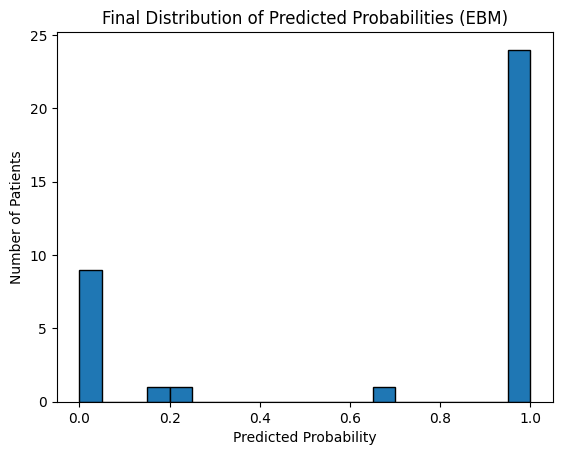

In [ ]:
# EBM with adjusted regularization to balance confidence
ebm = ExplainableBoostingClassifier(
    max_bins=12,        # allow some flexibility
    outer_bags=20,      # maintain bagging for stability
    interactions=3,     # slight feature interactions
    max_leaves=2,       # minimal complexity in trees
    learning_rate=0.02
)

ebm = train_ebm_with_progress(ebm, X_resampled, y_resampled)

y_pred_proba = ebm.predict_proba(X_test)[:, 1]

plt.hist(y_pred_proba, bins=20, edgecolor="black")
plt.xlabel("Predicted Probability")
plt.ylabel("Number of Patients")
plt.title("Final Distribution of Predicted Probabilities (EBM)")
plt.show()

In [ ]:
ebm_global = ebm.explain_global()
show(ebm_global)

In [ ]:
ebm_local = ebm.explain_local(X_test[:20], y_test[:20])
show(ebm_local)

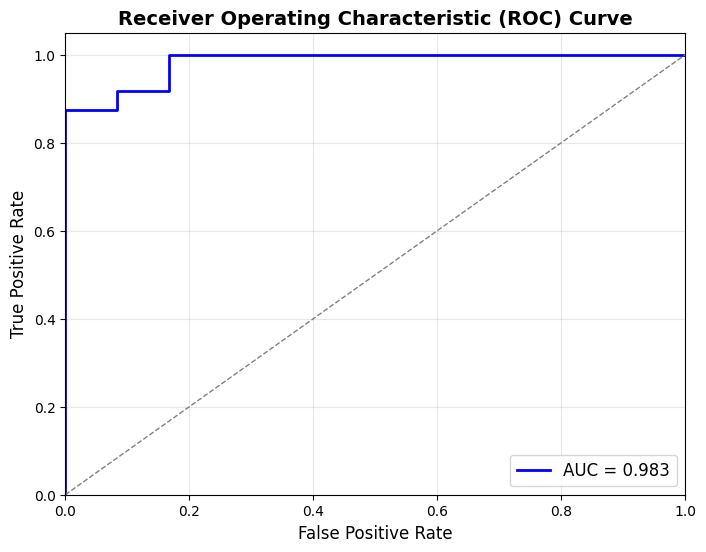

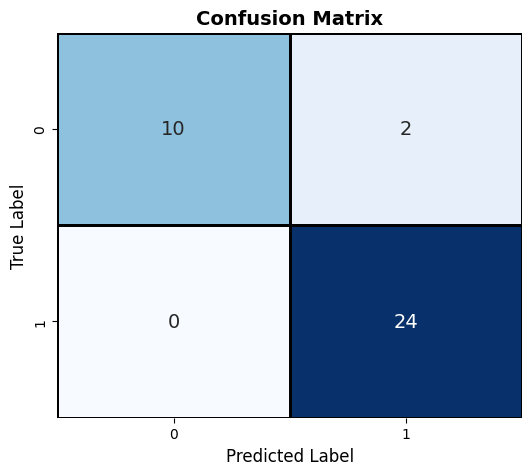

In [ ]:
#  ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = ["True Negative", "False Positive", "False Negative", "True Positive"]
cm_labels = np.array(labels).reshape(2, 2)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False, linewidths=2, linecolor='black', annot_kws={"size": 14})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.show()

## **Testing**

In [ ]:
import pickle
from google.colab import files

with open('/content/drive/MyDrive/Data/KIM_2024/ebm_model_v2.pkl', 'wb') as f:
    pickle.dump(ebm, f)

files.download('/content/drive/MyDrive/Data/KIM_2024/ebm_model_v2.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/Data/KIM_2024/ebm_model_v2.pkl"

try:
    with open(MODEL_PATH, "rb") as file:
        ebm = pickle.load(file)
    print("Model loaded successfully!")
except pickle.UnpicklingError:
    print("Error: The model file is corrupted or incompatible.")

Model loaded successfully!


In [ ]:
print(type(ebm))

<class 'interpret.glassbox._ebm._ebm.ExplainableBoostingClassifier'>


In [ ]:
if ebm:
    model_features = ebm.feature_names_in_
    X_test_ebm = combined_df[model_features]

    # predict probability and classify the first patient
    probability = ebm.predict_proba([X_test_ebm.iloc[0]])[0][1]  # extract probability
    predicted_class = "NAFLD (Sick)" if probability >= 0.5 else "Healthy"

    result = {
        "Patient Index": 0,
        "Probability of NAFLD": round(probability, 4),
        "Predicted Class": predicted_class
    }
    print("Prediction completed successfully!")

Prediction completed successfully!


In [ ]:
# Predict NAFLD probabilities using the trained EBM model
if ebm:
    predictions = ebm.predict_proba(patient_data[ebm.feature_names_in_])[:, 1]  # Get probabilities for class 1 (NAFLD)
    final_table['NAFLD Probability'] = predictions
    final_table['Predicted Class'] = final_table['NAFLD Probability'].apply(lambda x: 'NAFLD (Sick)' if x >= 0.5 else 'Healthy')

# Preview the final table with predictions
final_table.head()


In [ ]:
if ebm:
    feature_importance = pd.DataFrame({
        "Feature": ebm.explain_global().data()["names"],
        "Importance": ebm.explain_global().data()["scores"]
    }).sort_values(by="Importance", ascending=False)

    feature_importance_path = "/content/drive/MyDrive/Data/KIM_2024/ebm_feature_importance.csv"
    feature_importance.to_csv(feature_importance_path, index=False)

if ebm:
    predictions = ebm.predict_proba(combined_df[ebm.feature_names_in_])[:, 1]  # Get probabilities for class 1 (NAFLD)
    combined_df['NAFLD Probability'] = predictions
    combined_df['Predicted Class'] = combined_df['NAFLD Probability'].apply(lambda x: 'NAFLD (Sick)' if x >= 0.5 else 'Healthy')

# combined_df.insert(0, "ID", range(1, len(combined_df) + 1))
# combined_df["Gender"] = combined_df["Gender"].map({1:"Female", 0:"Male"})
# combined_df["Group"] = combined_df["Group"].map({0:"Healthy", 1:"NAFLD (Sick)"})

dataset_with_id_path = "/content/drive/MyDrive/Data/KIM_2024/nafld_dataset_with_id.csv"
combined_df.to_csv(dataset_with_id_path, index=False)

In [ ]:
combined_df.to_csv(dataset_with_id_path, index=False)

In [ ]:
combined_df.head()

ID  Gender  Age  Body Fat (%)  Visceral Fat (%)  Skeleton (%)  \
0   1  Female   44          40.2                12          30.7   
1   2  Female   33          32.6                 9          36.4   
2   3  Female   45          40.7                17          29.8   
3   4    Male   25          29.7                15          40.3   
4   5  Female   48          42.8                14          31.1   

   Bone Mass (kg)  Water (%)  Basal Metabolic Rate (kcal)  \
0             2.0       41.9                         1295   
1             2.8       48.6                         1435   
2             3.1       40.8                         1537   
3             3.7       51.3                         1906   
4             2.1       44.7                         1265   

   Chest Circumference (cm)  ...  Direct Bilirubin  Glucose  Insulin  \
0                        96  ...               5.7     5.30    10.54   
1                        99  ...               4.0     4.90     9.20   
2                       114  ...               5.7     5.33    17.40   
3                       110  ...               7.2     5.41    14.70   
4                        98  ...               5.4     5.67    11.60   

   Ferritin   CRP  Total Protein  Uric Acid         Group  NAFLD Probability  \
0      38.1  0.97           66.3     279.30  NAFLD (Sick)           0.992832   
1      74.3  1.00           64.1     150.40  NAFLD (Sick)           0.999372   
2     180.0  4.60           64.7     424.71  NAFLD (Sick)           0.999999   
3      96.5  0.78           73.9     286.00  NAFLD (Sick)           0.998977   
4     112.8  3.45           74.2     361.90  NAFLD (Sick)           1.000000   

   Predicted Class  
0     NAFLD (Sick)  
1     NAFLD (Sick)  
2     NAFLD (Sick)  
3     NAFLD (Sick)  
4     NAFLD (Sick)  

[5 rows x 33 columns]